# Apprenez une heuristique pour le Go

Dans ce TP notÃ©, vous devrez dÃ©ployer des methodes d'apprentissage automatique permettant d'Ã©valuer la qualitÃ© de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous gÃ©nÃ©rÃ©s par gnugo aprÃ¨s quelques coups contre lui mÃªme avec un niveau de difficultÃ© de 0. Par chaque plateau, nous avons lancÃ© 100 matchs de gnugo contre lui mÃªme, toujours avec un niveau 0, et comptÃ© le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un dÃ©roulement possible du match depuis le plateau de rÃ©fÃ©rence) correspond Ã  des mouvements choisis alÃ©atoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix alÃ©atoire par la qualitÃ© prÃ©dite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilitÃ© d'Ãªtre tirÃ©s).

Les donnÃ©es dont vous disposez sont brutes. Ce sera Ã  vous de proposer un format adÃ©quat pour utiliser ces donnÃ©es en entrÃ©e de votre rÃ©seau neuronal. 

## Comment sera Ã©valuÃ© votre modÃ¨le ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dÃ©pot de projet un fichier texte nommÃ© `my_predictions.txt` ayant une prÃ©diction par ligne (un simple flottant) qui donnera, dans le mÃªme ordre de la liste des exemples les scores que vous prÃ©disez pour chacune des entrÃ©es du fichier que nous vous aurons donnÃ©. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura crÃ©Ã© ce fichier, pour que l'on puisse Ã©ventuellement refaire vos prÃ©dictions.

Bien entendu, vous nous rendrez Ã©galement votre feuille jupyter **sous deux formats**, Ã  la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcÃ©ment relancer la feuille. Nous prendrons en compte les rÃ©sultats obtenus sur les prÃ©dictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera notÃ© ce TP ?

Il s'agit d'un TP notÃ©, donc il ne faudra pas y passer trop de temps. Nous attendons des prÃ©dictions correctes mais surtout des choix justifiÃ©s dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hÃ©sitez pas Ã  mettre des cellules de texte pour expliquer pourquoi vous avez Ã©tÃ© amenÃ©s Ã  faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les donnÃ©es (graphiques ou autre) qui permettent de comprendre comment vous avez Ã©vitÃ© l'overfitting.

Le fichier de vos prÃ©diction sera Ã©valuÃ© en se basant sur la qualitÃ© de vos prÃ©dictions. Nous mesurerons par exemple le nombre d'exemples dont votre prÃ©diction donnera la bonne valeur Ã  5%, 10%, 20%, 35%, 50% pour estimer sa qualitÃ©.


## Mise en route !

Voyons  comment lire les donnÃ©es


In [10]:
# Import du fichier d'exemples

def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", "samples-9x9.json.gz")
        print(" Done")

    with gzip.open("samples-9x9.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"examples")

We have 41563 examples


## ComprÃ©hension des donnÃ©es de chaque entrÃ©e

Voici une description de chaque exemple

In [41]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("DonnÃ©es brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(data,10)

Sample 10

DonnÃ©es brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


## DonnÃ©es en entrÃ©e et en sortie de votre modÃ¨le final

MÃªme si en interne, votre modÃ¨le va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrÃ©e les coordonnÃ©es des pierres noires et blanches et donnera le pourcentage de chance pour noir de gagner depuis cette position. 

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]`
- Vous devrez prÃ©dire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos donnÃ©es formattÃ©es en matrices numpy pour faire votre entrainement. On vous demande juste ici d'Ã©crire comment vous faites ces transformations, pour comprendre ce que vous avez dÃ©cidÃ© de mettre en entrÃ©e du rÃ©seau.

Voici le modÃ¨le de la fonction qui pourra Ãªtre appelÃ©e, au final :


In [158]:
def position_predict(black_stones, white_stones):

    # ... Votre tambouille interne pour placer les pierres comme il faut dans votre structure de donnÃ©es
    # et appeler votre modÃ¨le Keras (typiquement avec model.predict())
    prediction = None # model.predict(...) # A REMPLIR CORRECTEMENT
    
    return prediction

# Par exemple, nous pourrons appeler votre prÃ©diction ainsi

print("Prediction this sample:")
summary_of_example(data, 10)
print()
prediction = position_predict(data[10]["black_stones"], data[10]["white_stones"])
print("You predicted", prediction, "and the actual target was", data[10]["black_wins"]/data[10]["rollouts"])

# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant les nouvelles donnÃ©es que 
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de mÃ©thode permettant de gÃ©nÃ©rer le fichier de resultats demandÃ©s. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")



Prediction this sample:
Sample 10

DonnÃ©es brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games

You predicted None and the actual target was 0.6


The CDF curve shows that black has more chances to win, globally


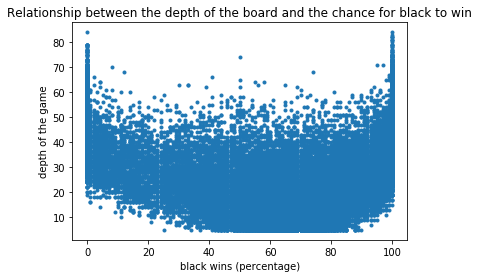

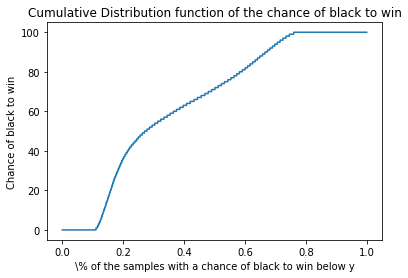

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least to planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



In [ ]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin




# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers

model = Sequential()

# ... A REMPLIR

model.summary()

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...